## Direct debit requires that a list of banking services be provided to employees base on:
* Thier place of employment
* Place of residence

This is an effort to automate the delivery of thjat information. For each employee, this script should:
1. Provide a list of banking services located within 1 (radial?) mile of their home address
2. Provide a map with the location of banking services coresponding to the list above (ennumerated?)
3. Provide a list of banking services located within 1 (radial?) mile of their work address
4. Provide a map with the location of banking services coresponding to the list above (ennumerated?)

For the purposes of this proof of concept, banking services will be defined to include:
* Bank branches
* ATM machines

Assumptions: 
1. Data will be provided in csv format
    * to include:
        * Name (First & Last)
        * Home Address
        * Office location & Address
        

## Set imports

In [138]:
#Imports first

import os
import matplotlib.pyplot as plt
import requests
import pandas as pd
from googlemaps import googlemaps
import json
import PIL.Image
import PIL.ImageOps
from io import BytesIO

#For reportlab pdfs
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes  import letter
from reportlab.lib.pagesizes  import landscape
from reportlab.platypus import Image, Table
import time

#### Import data

In [91]:
# SET file and path locations
file_loc = 'C:/Users/Jonathan/DirectDebit/data/'
file_path = file_loc + 'direct_debit_clean.csv'
ouput_loc = 'C:/Users/Jonathan/DirectDebit/deliver/'
pdf_file_name = 'direct_debit_poc.pdf'
apikey_path = "C:/Users/Jonathan/Google Drive/"


In [16]:
# Import data and check it!
df_clean = pd.read_csv(file_path)
df_clean.head()

,Unnamed: 0,First_name,Last_name,Email,LON,LAT,NUMBER,STREET,UNIT,CITY,DISTRICT,REGION,POSTCODE,ID,HASH,OFFICE_NUMBER,OFFICE_STREET,OFFICE_CITY,OFFICE_REGION,OFFICE_POSTCODE
0,0,Brandon,Newman,brandon.newman@directdebitsample.com,-78.963960,42.441394,11337,Dewey Road,NaN,Perrysburg,Cattaraugus,NY,NaN,CATT036895,e3b613190ea934d2,366,West Main Street,Concord,NY,NaN
1,1,Dominic,Pullman,dominic.pullman@directdebitsample.com,-78.252336,42.386628,8854,County Road 7E,NaN,Rushford,Allegany,NY,NaN,ALLE005555,88146015a1da33e6,7327,Groveland Station Road,Groveland,NY,NaN
2,2,Oliver,Murray,oliver.murray@directdebitsample.com,-77.831374,42.559236,3467,Route 436,NaN,Ossian,Livingston,NY,NaN,LIVI008863,b2d5265bd565c8e1,4,Ball Street,Barton,NY,NaN
3,3,Rebecca,Tucker,rebecca.tucker@directdebitsample.com,-76.360721,42.367440,103,Grove School Road,NaN,Caroline,Tompkins,NY,NaN,TOMP012017,35107fb4aea327f6,28,Jackson Creek Road,Horseheads,NY,NaN
4,4,Boris,Metcalfe,boris.metcalfe@directdebitsample.com,-75.847634,42.929323,8,Fenner Street,Apartment 4,Cazenovia,Madison,NY,NaN,MADI033910,5a830dd90d716201,1718,Seneca Road,Lodi,NY,NaN


In [144]:
# Make the data frame smaller -- just to save time

df_clean = df_clean[0:10]

##### Get API key -- use your own here!

In [17]:
# get api key from file - no, github, you can't have my api key
apikey_path = "C:/Users/Jonathan/Google Drive/"
with open(apikey_path + 'gm_config.config', 'r') as f:
    api_key = f.readline()
    api_key = api_key.strip()


#####  Function to create office address

In [50]:
# Define function for getting all the needed employee details

def create_employee_home_address(row): 
    home_address = str(row['NUMBER']) + " " + row['STREET'] + " " + row['CITY'] + " " + row['REGION']
    return home_address

def create_employee_office_address(row): 
    office_address = str(row['OFFICE_NUMBER']) + " " + row['OFFICE_STREET'] + " " + row['OFFICE_CITY'] + " " + row['OFFICE_REGION']
    return office_address

In [53]:
# test create_employee_home_address function
for index, row in df_clean.iterrows():
    test_home_address = create_employee_home_address(row)
    test_office_address = create_employee_office_address(row)
print([test_home_address, test_office_address])

['2 Shetland Circle Woodbury NY', '4 Howland Street Chester NY']


##### Function to get lat-lon

In [54]:
# Function to get lat-long as a dictionary from googlemaps api

def convert_address_to_lat_lon(address, api_key):
    gmaps = googlemaps.Client(key=api_key)
    lat = gmaps.geocode(address)[0]
    return (lat['geometry']['location']['lat'], lat['geometry']['location']['lng'])
    

In [65]:
# Test convert_address_to_lat_lon function
test_lat_lon = convert_address_to_lat_lon(test_office_address, api_key)
print(test_lat_lon)

(41.36238520000001, -74.271198)


#####  Create function to return banking service locations within 1 mile (1600 meters) of home address; limited to top ten results

In [104]:
# Define function for getting banking services near home address

def find_banking_services(query, location, bank_type, radius, api_key):
    gmaps = googlemaps.Client(key=api_key)
    banking_places = gmaps.places(query, location=location, type=bank_type, radius=radius)
    locations =[]
    for bank in banking_places['results'][0:9]:
        locations.append([bank['name'], bank['formatted_address']])
    return locations


In [69]:
# Test find_banking_services 

query = 'bank'
location = test_lat_lon  #home address reference from above
bank_type = 'atm'
radius = 1600

test_local_banking_services = find_banking_services(query, location, bank_type, radius)
test_local_banking_services

[['Cardtronics ATM', '48 Brookside Ave, Chester, NY 10918, United States'],
 ['Cardtronics ATM', '38 Brookside Ave, Chester, NY 10918, United States'],
 ['Citizens Bank', '38 Brookside Ave, Chester, NY 10918, United States'],
 ['Citizens Bank', '68 Brookside Ave, Chester, NY 10918, United States'],
 ['TD Bank', '78 Brookside Ave #101, Chester, NY 10918, United States'],
 ['ATM (Key Bank)', '135 Main St, Chester, NY 10918, United States'],
 ['ATM (Key Bank)', '74 Brookside Ave, Chester, NY 10918, United States'],
 ['KeyBank', '74 Brookside Ave, Chester, NY 10918, United States'],
 ['Keybank, National Association', 'NY-17M, Chester, NY 10918, United States']]

#### Create function to return map markers to be plotted

In [119]:
# function for converting banking services near an address to a list of markers to be plotted
def create_map_markers(marker_address_list):
    s = "|"
    return s.join(marker_address_list)


In [120]:
# Test create_map_markers

test_create_map_markers = create_map_markers([bank[1] for bank in test_local_banking_services])
test_create_map_markers


'48 Brookside Ave, Chester, NY 10918, United States|38 Brookside Ave, Chester, NY 10918, United States|38 Brookside Ave, Chester, NY 10918, United States|68 Brookside Ave, Chester, NY 10918, United States|78 Brookside Ave #101, Chester, NY 10918, United States|135 Main St, Chester, NY 10918, United States|74 Brookside Ave, Chester, NY 10918, United States|74 Brookside Ave, Chester, NY 10918, United States|NY-17M, Chester, NY 10918, United States'

In [121]:
create_map_markers([bank[1] for bank in test_local_banking_services])

'48 Brookside Ave, Chester, NY 10918, United States|38 Brookside Ave, Chester, NY 10918, United States|38 Brookside Ave, Chester, NY 10918, United States|68 Brookside Ave, Chester, NY 10918, United States|78 Brookside Ave #101, Chester, NY 10918, United States|135 Main St, Chester, NY 10918, United States|74 Brookside Ave, Chester, NY 10918, United States|74 Brookside Ave, Chester, NY 10918, United States|NY-17M, Chester, NY 10918, United States'

#####  Create function to return google map as png from banking services near address

In [180]:
# Define function that takes a list of markers and outputs a formatted map

def create_map_with_markers(marker_input, api_key):
    payload = {'size': '400x400', 
           'maptype': 'roadmap',
           'markers': marker_input,
               'key':api_key}
    r = requests.get('https://maps.googleapis.com/maps/api/staticmap?', params=payload)
    i = PIL.Image.open(BytesIO(r.content))
    converted_image = i.convert("RGBA")
    new_img = PIL.ImageOps.expand(converted_image,border=5,fill='black')
    new_img.save('C:/Users/Jonathan/DirectDebit/figures/map_image.png')
    path = 'C:/Users/Jonathan/DirectDebit/figures/map_image.png'
    return path



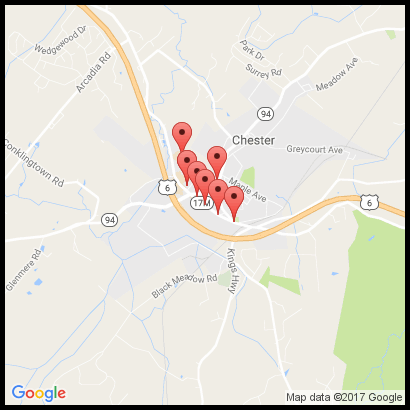

In [179]:
# test create_map_with_markers function

test_create_map_with_markers = create_map_with_markers(test_create_map_markers, api_key)
test_create_map_with_markers


## Generate PDFs based on bank locations and maps

In [164]:

#  Creates an individual pdf for specific employee
def generate_employee_handout(name, home_address, office_address, home_map, office_map, canvas):
    # Add Generic Company logo for the lolz
    company_logo = "C:/Users/Jonathan/DirectDebit/figures/generic-logo-hi.png"
    canvas.drawImage(company_logo, 15, 750, width=100, height=30)
    # header text
    canvas.setFont("Helvetica-Bold", 20, leading=None)
    canvas.drawCentredString(380, 755, "Direct Debit Banking Services Locations")

    # Add name
    canvas.setFont("Helvetica-Bold", 20, leading=None)
    canvas.drawString(25, 700, "Name: " + name)

    # add office details and map image
    canvas.setFont("Helvetica-Bold", 16, leading=None)
    canvas.drawString(25, 630, "Office: " + office_address)
    canvas.drawImage(office_map, 25, 425, width=200, height=200)

    # add home details and map image
    canvas.setFont("Helvetica-Bold", 16, leading=None)
    canvas.drawString(25, 365, "Home: " + home_address)
    canvas.drawImage(home_map, 25, 160, width=200, height=200)

    # add footer with time
    formatted_time = time.ctime()
    canvas.setFont("Helvetica", 10, leading=None)
    canvas.drawCentredString(520, 15, formatted_time)

    # store pdf
    canvas.showPage()
    print("PDF completed")


## Put it all together

In [169]:
pdf_file_name
# function that takes dataframe and produces pdf
def generate_pdf(data_file, pdf_file_name, api_key):
    c = canvas.Canvas(pdf_file_name, pagesize=letter)
    for index, row in data_file.iterrows():
        name = row['First_name'] + " " + row['Last_name']
        #print(name)
        #Create home details and map
        get_home_address = create_employee_home_address(row)
        get_home_lat_lon = convert_address_to_lat_lon(get_home_address, api_key)
        get_home_banking_services = find_banking_services(query='banking services', location=get_home_lat_lon, \
                                                          bank_type='atm', radius='1600', api_key=api_key)
        get_home_markers = create_map_markers([bank[1] for bank in get_home_banking_services])
        get_home_map = create_map_with_markers(get_home_markers, api_key)

        #Create home details and map
        get_office_address = create_employee_office_address(row)
        get_office_lat_lon = convert_address_to_lat_lon(get_office_address, api_key)
        get_office_banking_services = find_banking_services(query='banking services', location=get_office_lat_lon, \
                                                          bank_type='atm', radius='1600', api_key=api_key)
        get_office_markers = create_map_markers([bank[1] for bank in get_office_banking_services])
        get_office_map = create_map_with_markers(get_office_markers, api_key)
        generate_employee_handout(name=name, home_address=get_home_address, office_address=get_office_address, \
                                  home_map=get_home_map, office_map=get_office_map, canvas=c)
    c.save()



In [170]:
generate_pdf(df_clean, pdf_file_name,api_key)

PDF completed
PDF completed
PDF completed
PDF completed
PDF completed
PDF completed
PDF completed
PDF completed
PDF completed
PDF completed
